In [1]:
import pandas as pd

df = pd.read_csv('BusinessMasterFile.csv')
df.head()

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,...,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,RULEYEAR,LEVEL4,ACT1,ACT2,ACT3
0,19818,PALMER SECOND BAPTIST CHURCH,NaN,1050 THORNDIKE ST,PALMER,MA,01069-1507,3125,3,9,...,NaN,NaN,NaN,NaN,3514,1955,NaN,100,0.0,0.0
1,29215,ST GEORGE CATHEDRAL,NaN,523 E BROADWAY,SOUTH BOSTON,MA,02127-4415,2365,3,9,...,NaN,NaN,NaN,NaN,NaN,1972,NaN,100,0.0,0.0
2,587764,IGLESIA BETHESDA INC,NaN,157 ANDOVER ST,LOWELL,MA,01852-2348,0,3,3,...,NaN,NaN,NaN,X21,NaN,2004,X,0,NaN,NaN
3,635913,MINISTERIO APOSTOLICO JESUCRISTO ES EL SENOR INC,NaN,454 ESSEX ST,LAWRENCE,MA,01840-1242,0,3,3,...,NaN,NaN,NaN,X21,NaN,2004,X,0,NaN,NaN
4,765634,MERCY CHAPEL INTERNATIONAL,NaN,75 MORTON VILLAGE DR APT 408,MATTAPAN,MA,02126-2433,0,3,3,...,NaN,NaN,NaN,X20,NaN,2004,X,0,NaN,NaN


In [4]:
import missingno as msno

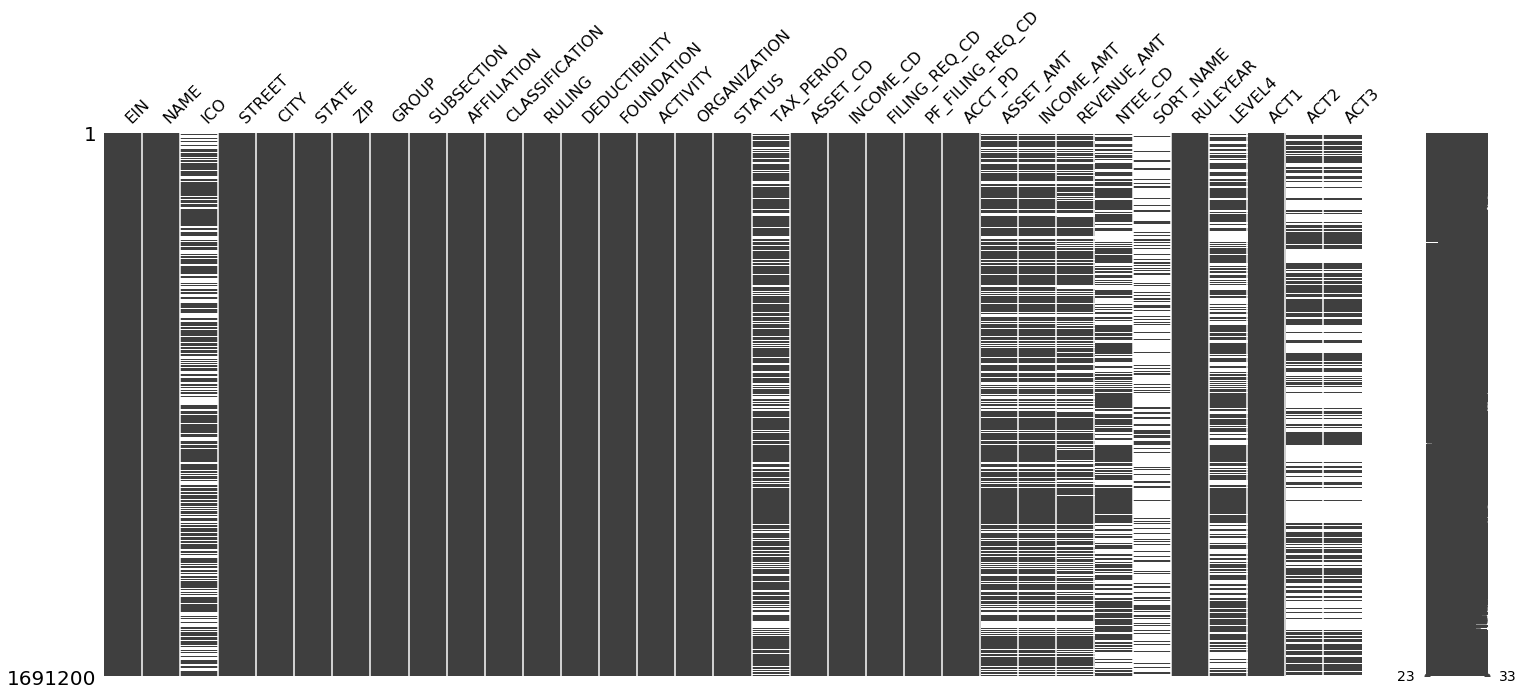

In [5]:
msno.matrix(df)

In [6]:
df.isna().sum()

EIN                       0
NAME                      0
ICO                  589563
STREET                    2
CITY                      0
STATE                  1267
ZIP                       0
GROUP                     0
SUBSECTION                0
AFFILIATION               0
CLASSIFICATION            0
RULING                    0
DEDUCTIBILITY             0
FOUNDATION                0
ACTIVITY                  0
ORGANIZATION              0
STATUS                    0
TAX_PERIOD           351197
ASSET_CD                  0
INCOME_CD                 0
FILING_REQ_CD             0
PF_FILING_REQ_CD          0
ACCT_PD                   0
ASSET_AMT            368826
INCOME_AMT           368826
REVENUE_AMT          479112
NTEE_CD              645285
SORT_NAME           1254791
RULEYEAR                  0
LEVEL4               645285
ACT1                      0
ACT2                 898743
ACT3                 898743
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691200 entries, 0 to 1691199
Data columns (total 33 columns):
EIN                 int64
NAME                object
ICO                 object
STREET              object
CITY                object
STATE               object
ZIP                 object
GROUP               int64
SUBSECTION          int64
AFFILIATION         int64
CLASSIFICATION      int64
RULING              int64
DEDUCTIBILITY       int64
FOUNDATION          int64
ACTIVITY            int64
ORGANIZATION        int64
STATUS              int64
TAX_PERIOD          float64
ASSET_CD            int64
INCOME_CD           int64
FILING_REQ_CD       int64
PF_FILING_REQ_CD    int64
ACCT_PD             int64
ASSET_AMT           float64
INCOME_AMT          float64
REVENUE_AMT         float64
NTEE_CD             object
SORT_NAME           object
RULEYEAR            int64
LEVEL4              object
ACT1                int64
ACT2                float64
ACT3                float64
dtypes: 

In [20]:
df.ACT1.value_counts(normalize=True)

0      5.314232e-01
100    5.612760e-02
590    2.571842e-02
602    2.168874e-02
263    1.562855e-02
994    1.556942e-02
360    1.534886e-02
907    1.074149e-02
200    1.039085e-02
102    1.024539e-02
995    9.099456e-03
205    8.637654e-03
350    8.561968e-03
319    7.993732e-03
279    7.770814e-03
593    7.585738e-03
290    6.732498e-03
400    6.611282e-03
149    6.096854e-03
599    5.681764e-03
119    5.667573e-03
311    5.493732e-03
900    5.163198e-03
300    5.014782e-03
123    4.691935e-03
600    4.490894e-03
320    4.378548e-03
460    3.823912e-03
998    3.738174e-03
362    3.620506e-03
           ...     
227    5.912961e-07
239    5.912961e-07
243    5.912961e-07
248    5.912961e-07
944    5.912961e-07
314    5.912961e-07
195    5.912961e-07
358    5.912961e-07
376    5.912961e-07
391    5.912961e-07
394    5.912961e-07
177    5.912961e-07
413    5.912961e-07
438    5.912961e-07
638    5.912961e-07
444    5.912961e-07
452    5.912961e-07
455    5.912961e-07
960    5.912961e-07
